In [10]:
from __future__ import print_function, division, absolute_import
from collections import Counter
import os
import sys
import orbithunter as orb
import numpy as np
import matplotlib.pyplot as plt
import time

# Deep Learning for Turbulence research.

This notebook mainly serves as an introduction for how one might use deep learning to create a predictive deep learning model for various equations. It is not too extensive now as it mainly serves as a simple introduction as to how one might want to
use a predictive model for statistical averages of turbulence

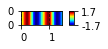

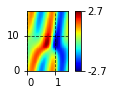

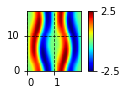

In [15]:
td = read_tileset("./data/tiles.h5", (0, 1, 2), ("default/double_streak", "default/defect", "default/wiggle"))
td[0].plot()
td[1].plot()
td[2].plot()

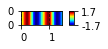

In [16]:
td[0].resize(16, td[0].m).plot()

In [17]:
from orbithunter.gluing import rediscretize_tileset, generate_symbol_arrays

In [18]:
td = rediscretize_tileset(td, new_shape=(16,16))
td

{0: EquilibriumOrbitKS({"shape": [16, 16], "basis": "field", "parameters": [0.0, 13.02, 0.0]}),
 1: RelativeOrbitKS({"shape": [16, 16], "basis": "field", "parameters": [17.151, 13.02, -3.313]}),
 2: AntisymmetricOrbitKS({"shape": [16, 16], "basis": "field", "parameters": [17.151, 17.591, 0.0]})}

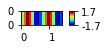

In [19]:
td[0].plot()

In [24]:
glue_shape = (3, 3)
symbol_arrays = generate_symbol_arrays(td, glue_shape=glue_shape, unique=True)

In [28]:
tiling_example = tile(symbol_arrays[0], td, OrbitKS, include_zero_dimensions=False)

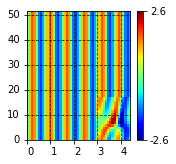

In [29]:
tiling_example.plot()

In [31]:
X = []
symbol_y = []
converge_y = []
for sa in symbol_arrays:
    tiling = tile(sa, td, OrbitKS).resize(32,32)
    X.append(tiling.state)
    symbol_counter = Counter(sa.ravel().tolist())
    symbol_y.append([symbol_counter[0]/sa.size, symbol_counter[1]/sa.size, symbol_counter[2]/sa.size])
X = np.array(X)
X = np.reshape(X, (*X.shape, 1))
y = np.array(symbol_y)

If we use a softmax layer, the output can be interpreted as a probability, which means that the total is conserved, such that if we multiply by the number of symbols we can get back an estimate that conserves the number of tiles.  

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, Activation
from sklearn.model_selection import train_test_split

X = (X - X.mean()) / X.std()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sample_size = X.shape[0]

cnn = Sequential()
cnn.add(Conv2D(filters=32, kernel_size=8, padding='valid', input_shape=X.shape[1:]
               ))
cnn.add(AveragePooling2D(pool_size=2))
cnn.add(Activation('relu'))

cnn.add(Conv2D(filters=8, kernel_size=8,
               padding='valid'
               ))
cnn.add(AveragePooling2D(pool_size=2))
cnn.add(Activation('relu'))
cnn.add(Flatten())
cnn.add(Dense(int(X[0].size)))
cnn.add(Dense(y.shape[1], activation='softmax'))
cnn.compile(loss='mse', optimizer='adam')

In [34]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 25, 25, 32)        2080      
_________________________________________________________________
average_pooling2d (AveragePo (None, 12, 12, 32)        0         
_________________________________________________________________
activation (Activation)      (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 8)           16392     
_________________________________________________________________
average_pooling2d_1 (Average (None, 2, 2, 8)           0         
_________________________________________________________________
activation_1 (Activation)    (None, 2, 2, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 32)                0

In [35]:
history = cnn.fit(X_train, y_train, validation_data=(X_test, y_test), verbose=1, epochs=100)

Epoch 1/100
55/55 [==============================] - 1s 16ms/step - loss: 0.0130 - val_loss: 0.0044
Epoch 2/100
55/55 [==============================] - 1s 13ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 3/100
55/55 [==============================] - 1s 14ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 4/100
55/55 [==============================] - 1s 13ms/step - loss: 8.9406e-04 - val_loss: 0.0013
Epoch 5/100
55/55 [==============================] - 1s 13ms/step - loss: 6.3843e-04 - val_loss: 7.4203e-04
Epoch 6/100
55/55 [==============================] - 1s 14ms/step - loss: 5.7863e-04 - val_loss: 5.4217e-04
Epoch 7/100
55/55 [==============================] - 1s 14ms/step - loss: 5.9263e-04 - val_loss: 4.7804e-04
Epoch 8/100
55/55 [==============================] - 1s 13ms/step - loss: 5.2734e-04 - val_loss: 5.7944e-04
Epoch 9/100
55/55 [==============================] - 1s 14ms/step - loss: 4.8097e-04 - val_loss: 3.6310e-04
Epoch 10/100
55/55 [==============================] - 1s

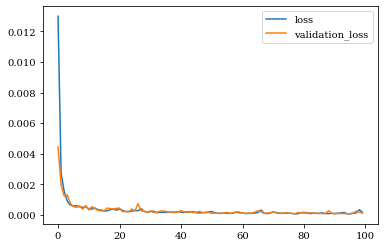

In [36]:
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False

_ = plt.plot(history.history['loss'])
_ = plt.plot(history.history['val_loss'])
_ = plt.legend(('loss', 'validation_loss'))
_ = plt.show()

In [ ]:
t79p778_x37p297

In [38]:
example_orbit_ = read_h5('./data/OrbitKS.h5', 't79p778_x37p297')

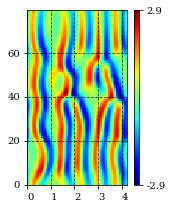

In [39]:
example_orbit_.plot()

In [41]:
example_orbit_ = example_orbit_.resize(32,32)

In [44]:
print('Example x', example_orbit_.x, 'Sum(x) for Tiles', td[0].x + td[1].x + td[2].x)

Example x 37.29708818660391 Sum(x) for Tiles 43.63019423747212


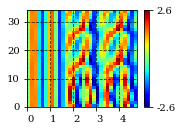

In [46]:
guess_symbol_array = np.array([[0,1,1],[0,1,1],[0,2,2]])
approximate_tiling = tile(guess_symbol_array, td, OrbitKS).resize(32, 32)
approximate_tiling.plot()

In [47]:
np.matrix(guess_symbol_array)

matrix([[0, 1, 1],
        [0, 1, 1],
        [0, 2, 2]])

In [49]:
test_converge_result = hunt(approximate_tiling.transform(to='modes'),
                                method=('adj', 'lstsq'),
                                preconditioning=[True, False],
                                pexp=(1,4),
                           verbose=True)
test_tiling = test_converge_result.orbit


-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : OrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [34.302, 42.106, 0]})
Constraints : {'t': False, 'x': False, 's': True}
Initial cost : 802.4324401287203
Target cost tolerance : 1e-06
Maximum iteration number : 10000
Preconditioning : True
-------------------------------------------------------------------------------------------------
#################################################
 cost=1.1452274 after 5000 adjoint descent steps. Parameters=(35.269933555636385, 42.106385068290805, 0.0)
#################################################
maximum number of iterations reached, terminating with cost 0.8664766284428467.


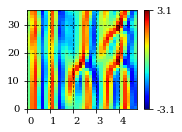

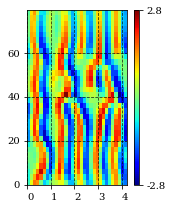

(None, None)

In [50]:
test_tiling.plot(), example_orbit_.plot()

In [51]:
prediction_for_test = cnn.predict(test_tiling.transform(to='field').state.reshape(1, 32, 32, 1))
np.round(prediction_for_test * sa.size)

array([[3., 5., 1.]], dtype=float32)

In [52]:
prediction_for_target = cnn.predict(example_orbit_.transform(to='field').state.reshape(1, 32, 32, 1))
np.round(prediction_for_target * sa.size)

array([[7., 2., 0.]], dtype=float32)

In [53]:
prediction_for_target_reflection = cnn.predict(example_orbit_.transform(to='field').reflection().state.reshape(1, 32, 32, 1))
np.round(prediction_for_target_reflection * sa.size)

array([[1., 7., 1.]], dtype=float32)

In [54]:
predictions = []
for n in range(32):
    for m in range(32):
        prediction_for_target_roll = cnn.predict(np.roll(np.roll(example_orbit_.transform(to='field').state,
                                                                 m,axis=1),n,axis=0).reshape(1, 32, 32, 1))
        predictions.extend(np.round(prediction_for_target_roll * sa.size))
        
predictions = np.array(predictions).reshape(-1, 3)

(array([276.,   0., 334.,   0., 264.,   0., 124.,   0.,  19.,   7.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

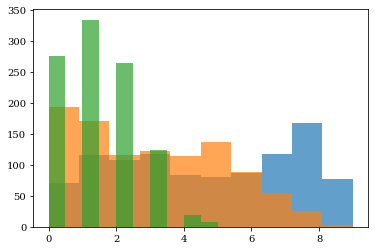

In [55]:
predictions
plt.hist(predictions[:, 0], alpha=0.7)
plt.hist(predictions[:, 1], alpha=0.7)
plt.hist(predictions[:, 2], alpha=0.7)

In [56]:
np.round(np.mean(predictions, axis=0))

array([5., 3., 1.], dtype=float32)

In [57]:
prediction_for_target_reflection

array([[0.15314543, 0.73506486, 0.11178966]], dtype=float32)

In [58]:
y_bottleneck = []
for sa in symbol_arrays:
    tiling = rediscretize(tile(sa, td, OrbitKS), new_shape=(32, 32))
    y_bottleneck.append(gudhi_distance(tiling, example_orbit_, metric='bottleneck'))
y = np.array(y_bottleneck).reshape(-1,1)

NameError: name 'rediscretize' is not defined

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, Activation
from sklearn.model_selection import train_test_split

X = (X - X.mean()) / X.std()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sample_size = X.shape[0]

bottleneck_cnn = Sequential()
bottleneck_cnn.add(Conv2D(filters=32, kernel_size=8, padding='valid', input_shape=X.shape[1:]
               ))
bottleneck_cnn.add(AveragePooling2D(pool_size=2))
bottleneck_cnn.add(Activation('relu'))

bottleneck_cnn.add(Conv2D(filters=8, kernel_size=8,
               padding='valid'
               ))
bottleneck_cnn.add(AveragePooling2D(pool_size=2))
bottleneck_cnn.add(Activation('relu'))
bottleneck_cnn.add(Flatten())
bottleneck_cnn.add(Dense(int(sample_size)))
bottleneck_cnn.add(Dense(y.shape[1], activation='relu'))
bottleneck_cnn.compile(loss='mse', optimizer='adam')
bottleneck_cnn.summary()

In [ ]:
history = bottleneck_cnn.fit(X_train, y_train, validation_data=(X_test, y_test), verbose=1, epochs=100)

As a baseline, let's see how well it predicts the distance between the example orbit and itself: The expected value is of course, 0.

In [ ]:
gudhi_distance(example_orbit_, example_orbit_, metric='bottleneck')

In [ ]:
bottleneck_cnn.predict(example_orbit_.transform(to='field').state.reshape(1, 32, 32, 1))

In [ ]:
bottleneck_cnn.predict(test_tiling.transform(to='field').state.reshape(1, 32, 32, 1))

In [ ]:
y_predict = bottleneck_cnn.predict(X_test)

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
_ = ax.scatter(y_test, y_predict, s=5)
_ = ax.plot([0,y_test.max()],[0,y_test.max()], color='r')
_ = plt.xlabel('True value')
_ = plt.ylabel('Predicted value')
_ = plt.show()

In [ ]:
X, y = list_of_orbits, list_of_predictive_quantities
orbit_cnn(X, y)